# AXI Proxy

In [1]:
import logging
import re
import subprocess
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
from fpga_mngr_interface.FpgaManagerInterface import FpgaManagerInterface
from zynqmp_pl_ps import Udmabuf, UioDev

## Programming the FPGA

We check if the FPGA is programmed, and if that is not the case, we program it with the appropriate bitstream and device tree overlay.

In [2]:
# logging.basicConfig(level=logging.DEBUG)

fmi = FpgaManagerInterface()
is_programmed = fmi.is_programmed()

try:
    UioDev.get_uio_dev_file("AxiProxy", "hp")
    ap_found = True
except RuntimeError:
    ap_found = False

print(f"is programmed: {is_programmed}, AXI Proxy found: {ap_found}")

if not is_programmed or not ap_found:
    print("Re-programming the FPGA")
    fmi.remove()
    fmi.program_bitstream(
        "/lib/firmware/xilinx/axi_proxy/axi_proxy.bit.bin",
        "/lib/firmware/xilinx/axi_proxy/axi_proxy.dtbo",
    )

is programmed: True, AXI Proxy found: False
Re-programming the FPGA


## Infrastructure around `app-proxy`

In [3]:
@dataclass(frozen=True)
class Config:
    use_osync: bool
    axi_cache: int
    axi_prot: int
    axi_user: int


@dataclass(frozen=True)
class Stats:
    dur_wr: int
    dur_rd: int

In [4]:
RE_STATS = re.compile(r"stats: dur_wr = (?P<dur_wr>\d+), dur_rd = (?P<dur_rd>\d+)")

def run_ap(interface: str, config: Config) -> Stats:
    args = ["app-axi-proxy",
            "--interface", interface,
            "--data", *[str(xi) for xi in np.random.randint(0, np.iinfo(np.uint32).max, 4)],
            "--axi-prot", str(config.axi_prot),
            "--axi-cache", str(config.axi_cache),
            "--axi-user", str(config.axi_user)]

    if config.use_osync:
        args.append("--use-osync")

    resp = subprocess.check_output(args)

    for line in resp.decode("ascii").split("\n"):
        if m := RE_STATS.match(line):
            m_dict = {k: int(v) for k,v in m.groupdict().items()}
            return Stats(**m_dict)
        
    raise RuntimeError("Unable to find the 'stats:' line")

## Measurement configuration

In [5]:
udmabuf = Udmabuf.Udmabuf("axi:udmabuf@0x0")
BUFFER_SIZE = udmabuf.buf_size
print(f"Buffer size: {BUFFER_SIZE}")
del udmabuf

Buffer size: 33554432


In [6]:
NR_MEAS_PER_PORT = 100

CONFIGS = {
    "hp": Config(use_osync=True, axi_cache=0, axi_prot=0, axi_user=0),
    "hpc": Config(use_osync=False, axi_cache=15, axi_prot=2, axi_user=1),
    "acp": Config(use_osync=False, axi_cache=15, axi_prot=2, axi_user=1),
}

## Measurement

In [7]:
np.random.seed(1234)

meas = dict()

for interface, config in CONFIGS.items():

    durs_rd = []
    durs_wr = []

    print("==================================")
    print(interface)
    for i in range(NR_MEAS_PER_PORT):
        stats = run_ap(interface, config)
        print(stats, end=", ", flush=True)
        durs_rd.append(stats.dur_rd)
        durs_wr.append(stats.dur_wr)
    print("")

    meas[interface] = dict()
    meas[interface]["rd"] = durs_rd
    meas[interface]["wr"] = durs_wr

hp
Stats(dur_wr=37, dur_rd=70), Stats(dur_wr=36, dur_rd=70), Stats(dur_wr=36, dur_rd=64), Stats(dur_wr=37, dur_rd=70), Stats(dur_wr=36, dur_rd=64), Stats(dur_wr=37, dur_rd=64), Stats(dur_wr=36, dur_rd=64), Stats(dur_wr=37, dur_rd=77), Stats(dur_wr=37, dur_rd=64), Stats(dur_wr=36, dur_rd=70), Stats(dur_wr=36, dur_rd=70), Stats(dur_wr=36, dur_rd=70), Stats(dur_wr=36, dur_rd=69), Stats(dur_wr=36, dur_rd=64), Stats(dur_wr=36, dur_rd=74), Stats(dur_wr=36, dur_rd=70), Stats(dur_wr=36, dur_rd=70), Stats(dur_wr=36, dur_rd=69), Stats(dur_wr=36, dur_rd=69), Stats(dur_wr=37, dur_rd=69), Stats(dur_wr=36, dur_rd=72), Stats(dur_wr=36, dur_rd=69), Stats(dur_wr=36, dur_rd=69), Stats(dur_wr=36, dur_rd=159), Stats(dur_wr=36, dur_rd=64), Stats(dur_wr=37, dur_rd=70), Stats(dur_wr=36, dur_rd=64), Stats(dur_wr=37, dur_rd=70), Stats(dur_wr=36, dur_rd=69), Stats(dur_wr=37, dur_rd=146), Stats(dur_wr=36, dur_rd=64), Stats(dur_wr=37, dur_rd=64), Stats(dur_wr=36, dur_rd=64), Stats(dur_wr=37, dur_rd=64), Stats(dur

Stats(dur_wr=31, dur_rd=24), Stats(dur_wr=28, dur_rd=15), Stats(dur_wr=34, dur_rd=13), Stats(dur_wr=27, dur_rd=24), Stats(dur_wr=34, dur_rd=19), Stats(dur_wr=30, dur_rd=24), Stats(dur_wr=31, dur_rd=25), Stats(dur_wr=34, dur_rd=20), Stats(dur_wr=27, dur_rd=24), Stats(dur_wr=33, dur_rd=14), Stats(dur_wr=34, dur_rd=24), Stats(dur_wr=26, dur_rd=22), Stats(dur_wr=33, dur_rd=13), Stats(dur_wr=34, dur_rd=13), Stats(dur_wr=28, dur_rd=13), Stats(dur_wr=33, dur_rd=14), Stats(dur_wr=34, dur_rd=24), Stats(dur_wr=27, dur_rd=15), Stats(dur_wr=30, dur_rd=14), Stats(dur_wr=34, dur_rd=24), Stats(dur_wr=26, dur_rd=24), Stats(dur_wr=26, dur_rd=17), Stats(dur_wr=33, dur_rd=25), Stats(dur_wr=33, dur_rd=24), Stats(dur_wr=26, dur_rd=23), Stats(dur_wr=33, dur_rd=16), Stats(dur_wr=25, dur_rd=19), Stats(dur_wr=27, dur_rd=24), Stats(dur_wr=25, dur_rd=24), Stats(dur_wr=28, dur_rd=21), Stats(dur_wr=35, dur_rd=13), Stats(dur_wr=34, dur_rd=14), Stats(dur_wr=26, dur_rd=23), Stats(dur_wr=30, dur_rd=24), Stats(dur_wr=2

## Plotting

In [8]:
@dataclass
class MeasData:
    hp: np.array
    hpc: np.array
    acp: np.array


def process_meas(data: dict, tx_type: str):
    hp = np.array(data["hp"][tx_type])
    hpc = np.array(data["hpc"][tx_type])
    acp = np.array(data["acp"][tx_type])

    return MeasData(hp=hp, hpc=hpc, acp=acp)

def plot_graph_hist(
    meas_hp: np.array,
    meas_hpc: np.array,
    meas_acp: np.array,
    title: str,
):
    fig = plt.figure(figsize=(12, 8))
    ax1, ax2 = fig.subplots(1, 2, gridspec_kw={"width_ratios": [3, 1]}, sharey=True)

    ax1.plot(meas_hp, label="HP")
    ax1.plot(meas_hpc, label="HPC")
    ax1.plot(meas_acp, label="ACP")
    ax1.grid(True)
    ax1.legend(loc="upper right")
    ax1.set_ylabel("delay [clk cycles]")
    ax1.set_xlabel("iteration")

    delay_max = np.max([np.max(meas_hp), np.max(meas_hpc), np.max(meas_acp)])
    delay_min = np.min([np.min(meas_hp), np.min(meas_hpc), np.min(meas_acp)])

    HIST_CONF = {
        "orientation": "horizontal",
        "alpha": 0.7,
    }
    ax2.hist(meas_hp, label="HP", bins=30, range=(delay_min, delay_max), **HIST_CONF)
    ax2.hist(meas_hpc, label="HPC", bins=30, range=(delay_min, delay_max), **HIST_CONF)
    ax2.hist(meas_acp, label="ACP", bins=30, range=(delay_min, delay_max), **HIST_CONF)
    ax2.grid(True)
    ax2.legend(loc="upper right")
    ax2.set_xlabel("counts")

    fig.suptitle(title)

In [9]:
data_read = process_meas(meas, "rd")
data_write = process_meas(meas, "wr")

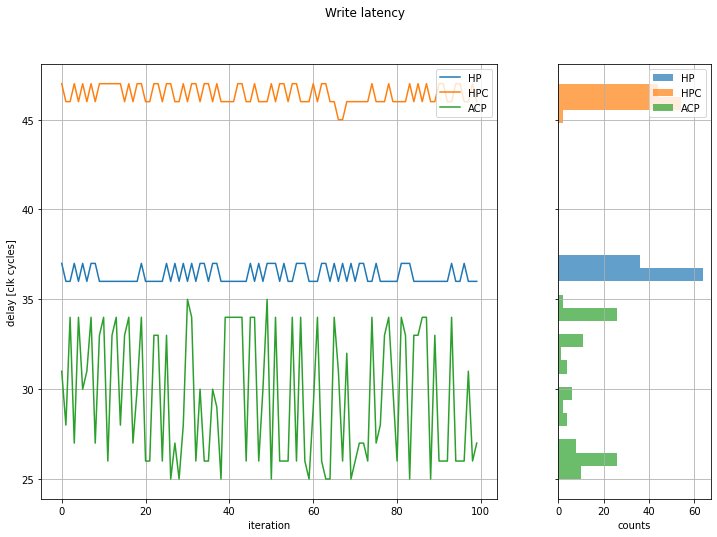

In [10]:
plot_graph_hist(
    data_write.hp, data_write.hpc, data_write.acp, "Write latency"
)

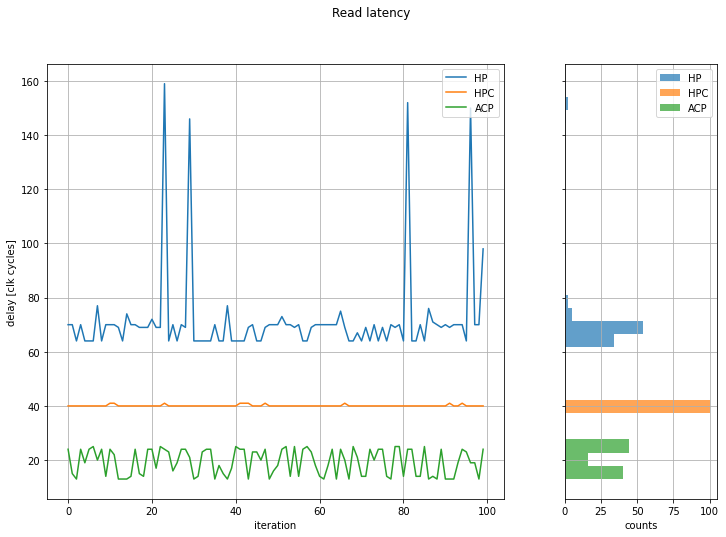

In [11]:
plot_graph_hist(
    data_read.hp, data_read.hpc, data_read.acp, "Read latency"
)

## Conclusion
